In [3]:
import os, sys
from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision import models
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
print('Using device:', device)

DETECTION_SCORE_THRESHOLD = 0.40

Using device: cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
images_dir = '/content/drive/MyDrive/Assignment_5_Images'
save_dir = '/content/drive/MyDrive/Results'
image_names = [img_file for img_file in os.listdir(images_dir) if img_file[-4:] in ['.jpg', '.png']]
print('Total num of images', len(image_names))
print(image_names)
for i in range(len(image_names)):
  img = cv2.imread(os.path.join(images_dir, image_names[i]))
  cv2.imwrite(os.path.join(save_dir, 'inp_image_{}.jpg'.format(i)), img)

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Total num of images 12
['000000037777.jpg', '000000397133.jpg', '000000252219.jpg', 'elephant.jpg', 'noisy_elephant.png', 'cat_background_clutter.jpg', 'cat_illumination.jpg', 'person_many.jpg', 'person_and_bust.jpg', 'bus.jpg', 'airplane.jpg', 'person_with_pizza.jpg']


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


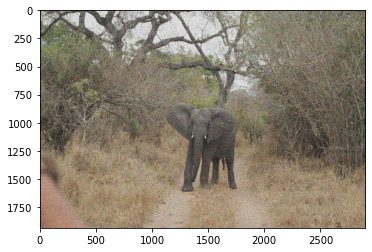

In [53]:
import cv2
img = cv2.imread(os.path.join(images_dir, image_names[4]))[:,:,::-1]
plt.imshow(img)
plt.show()

**Faster R-CNN**

In [10]:
def load_faster_rcnn():
  model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  model.to(device)
  model.eval()
  return model

def predict_for_fasterrcnn(model):
  predictions = []
  # Define a transform to convert PIL 
  # image to a Torch tensor
  transform = transforms.Compose([transforms.ToTensor()])
  for file_ in image_names:
    image_path = os.path.join(images_dir, file_)
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
      predict_ = model(image_tensor)
      filtered_indices = predict_[0]['scores'] > DETECTION_SCORE_THRESHOLD
      predict_[0]['boxes'] = predict_[0]['boxes'][filtered_indices].cpu().numpy()
      predict_[0]['scores'] = predict_[0]['scores'][filtered_indices].cpu().numpy()
      predict_[0]['labels'] = predict_[0]['labels'][filtered_indices].cpu().numpy()
      predictions.append(predict_[0])
  return predictions

In [54]:
faster_rcnn_model = load_faster_rcnn()
predictions = predict_for_fasterrcnn(faster_rcnn_model)

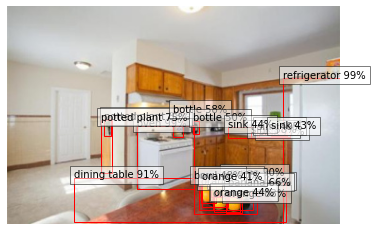

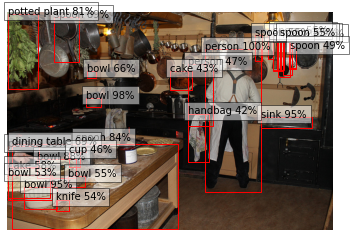

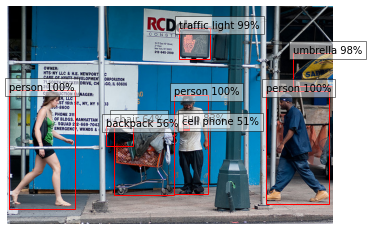

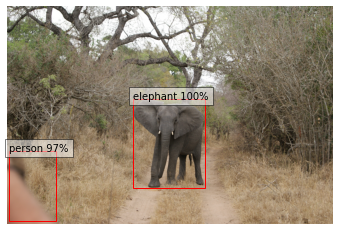

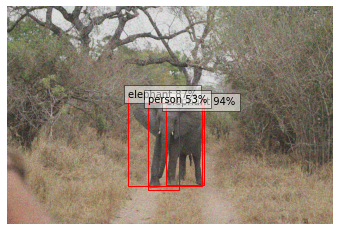

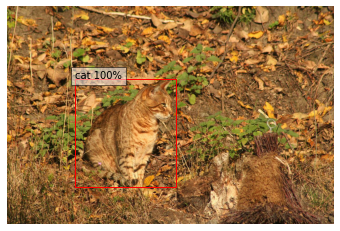

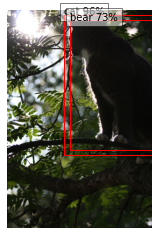

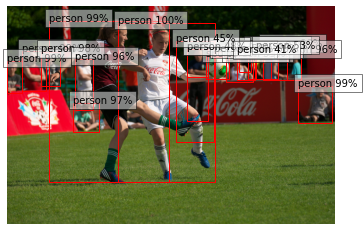

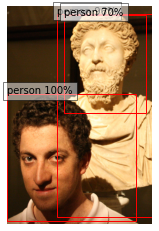

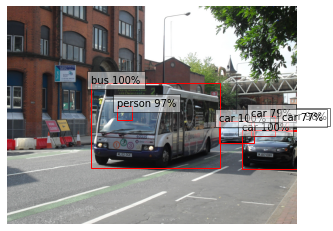

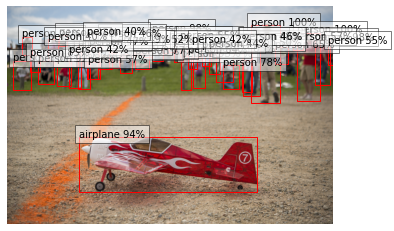

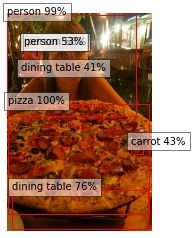

In [60]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
for image_idx in range(len(predictions)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = Image.open(os.path.join(images_dir, image_names[image_idx]))
    ax.imshow(np.array(image))
    # ...with detections
    ax.set_axis_off()
    bboxes = predictions[image_idx]['boxes']
    classes = predictions[image_idx]['labels']
    confidences = predictions[image_idx]['scores']
    #print(bboxes.shape, classes.shape, confidences.shape)
    for idx in range(bboxes.shape[0]):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        #print(bboxes[idx], classes[idx], confidences[idx])
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(COCO_INSTANCE_CATEGORY_NAMES[classes[idx]], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig( os.path.join(save_dir, 'frcnn_image_{}.png'.format(image_idx)), bbox_inches='tight', pad_inches=0 )
plt.show()

**Single Shot Detector**

In [22]:
def load_ssd():
  model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
  utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')
  model.to('cuda')
  model.eval()
  return model, utils

def prepare_inputs_for_ssd(img_paths, ssd_utils):
  inputs = [ssd_utils.prepare_input(img_path) for img_path in img_paths]
  tensor = ssd_utils.prepare_tensor(inputs)
  return inputs, tensor

def predict_for_ssd(ssd_model, input_tensors):
  with torch.no_grad():
    detections_batch = ssd_model(tensor)
    results_per_input = ssd_utils.decode_results(detections_batch)
    best_results_per_input = [ssd_utils.pick_best(results, 0.40) for results in results_per_input]
    return best_results_per_input

ssd_model, ssd_utils = load_ssd()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [56]:
img_paths = [os.path.join(images_dir, file_name) for file_name in image_names]
print(img_paths)
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]
inputs, tensor = prepare_inputs_for_ssd(img_paths, ssd_utils)

['/content/drive/MyDrive/Assignment_5_Images/000000037777.jpg', '/content/drive/MyDrive/Assignment_5_Images/000000397133.jpg', '/content/drive/MyDrive/Assignment_5_Images/000000252219.jpg', '/content/drive/MyDrive/Assignment_5_Images/elephant.jpg', '/content/drive/MyDrive/Assignment_5_Images/noisy_elephant.png', '/content/drive/MyDrive/Assignment_5_Images/cat_background_clutter.jpg', '/content/drive/MyDrive/Assignment_5_Images/cat_illumination.jpg', '/content/drive/MyDrive/Assignment_5_Images/person_many.jpg', '/content/drive/MyDrive/Assignment_5_Images/person_and_bust.jpg', '/content/drive/MyDrive/Assignment_5_Images/bus.jpg', '/content/drive/MyDrive/Assignment_5_Images/airplane.jpg', '/content/drive/MyDrive/Assignment_5_Images/person_with_pizza.jpg']


In [57]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)
results_per_input = ssd_utils.decode_results(detections_batch)
best_results_per_input = [ssd_utils.pick_best(results, 0.30) for results in results_per_input]
classes_to_labels = ssd_utils.get_coco_object_dictionary()

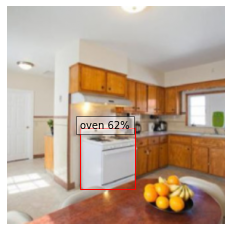

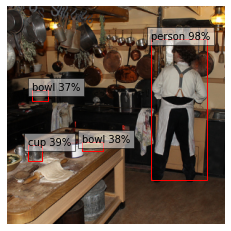

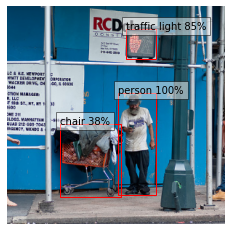

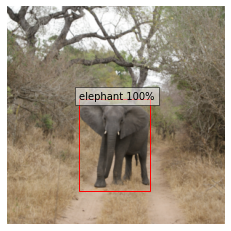

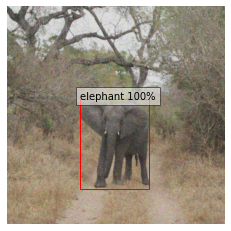

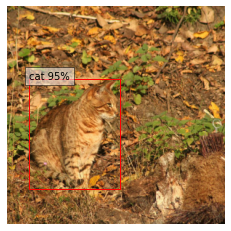

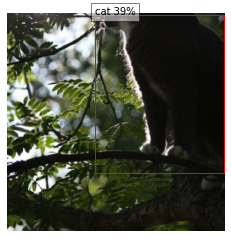

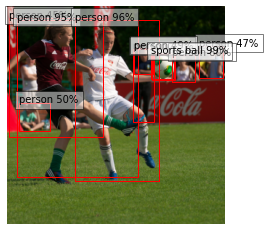

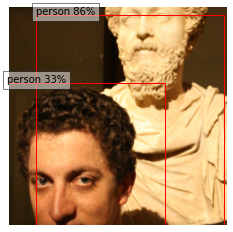

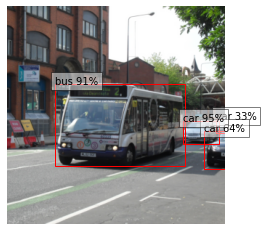

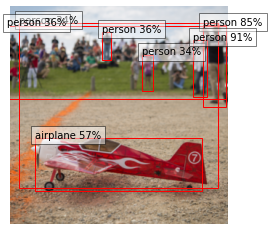

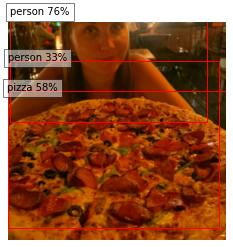

In [59]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    ax.set_axis_off()
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig( os.path.join(save_dir, 'ssd_image_{}.png'.format(image_idx)), bbox_inches='tight', pad_inches=0 )
plt.show()